In [1]:
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import scipy.linalg
import torch
from torch.utils.data import Dataset

In [4]:
# parameters
coords_voltages = 'coords_voltages/coords_voltages_C0016.mat'
square_size = 1.6

data = scipy.io.loadmat(coords_voltages)
points = np.flip(data['coords'][0:625, 0:2], axis=1)
voltage = data['voltages']
points = -points * 0.01 * square_size

In [5]:
class MyData(Dataset):
    def __init__(self, coordiantes, voltage):
        self.coordinates = coordiantes
        self.voltage = voltage

    def __getitem__(self, idx): 

        return self.coordinates[idx], self.voltage[idx]

    def __len__(self):
        return self.voltage.shape[0]

In [6]:
class Model(torch.nn.Module):
    def __init__(self,num_i,num_h,num_o):
        super(Model,self).__init__()
        
        self.linear1=torch.nn.Linear(num_i,num_h)
        self.tanh1=torch.nn.Tanh()
        self.linear2=torch.nn.Linear(num_h,num_h)
        self.tanh2=torch.nn.Tanh()
        self.linear3=torch.nn.Linear(num_h,num_o)
  
    def forward(self, x):
        x = self.linear1(x)
        x = self.tanh1(x)
        x = self.linear2(x)
        x = self.tanh2(x)
        x = self.linear3(x)

        return x

In [7]:
data_train = MyData(voltage, points)

data_loader_train = torch.utils.data.DataLoader(dataset = data_train,
                                                batch_size = 32,
                                                shuffle = True)

In [8]:
model = Model(2,7,2)
loss_function = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())
epochs = 5000

for epoch in range(epochs) :
    sum_loss=0
    train_correct=0

    for data in data_loader_train:
        inputs, labels = data # inputs: [100,2]
        inputs_new = torch.tensor(inputs, dtype=torch.float32)
        labels_new = torch.tensor(labels, dtype=torch.float32)
        outputs=model(inputs_new) # outputs: [100,2]

        optimizer.zero_grad()
        loss = loss_function(outputs,labels_new)
        loss.backward()
        optimizer.step()
        sum_loss += loss.item()
    if epoch % 1000 == 0:
        print('epoch: {}, loss: {}'.format(epoch, sum_loss))

model.train()

/var/folders/dp/_xrz74d50vgb_z54bv1pbcrm0000gn/T/ipykernel_52320/3402197429.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  inputs_new = torch.tensor(inputs, dtype=torch.float32)
/var/folders/dp/_xrz74d50vgb_z54bv1pbcrm0000gn/T/ipykernel_52320/3402197429.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels_new = torch.tensor(labels, dtype=torch.float32)


epoch: 0, loss: 1.0134750679135323
epoch: 1000, loss: 2.045799266170434e-05
epoch: 2000, loss: 1.455867453614701e-05
epoch: 3000, loss: 1.6615142726550403e-05
epoch: 4000, loss: 2.2324735880374647e-05


Model(
  (linear1): Linear(in_features=2, out_features=7, bias=True)
  (tanh1): Tanh()
  (linear2): Linear(in_features=7, out_features=7, bias=True)
  (tanh2): Tanh()
  (linear3): Linear(in_features=7, out_features=2, bias=True)
)

In [9]:
vertices_data = scipy.io.loadmat('transforms/vertices.mat')
vertices_voltage = vertices_data['vertices']

<function matplotlib.pyplot.show(close=None, block=None)>

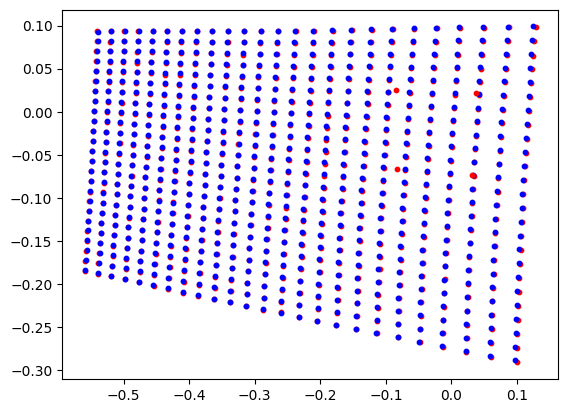

In [10]:
points_inferred = model(torch.tensor(voltage, dtype = torch.float32))
points_inferred = points_inferred.detach().numpy()
points_inferred_test = model(torch.tensor(vertices_voltage.T, dtype = torch.float32)).detach().numpy()
plt.figure
for i in range(points.shape[0]):
    plt.scatter(points[i,0], points[i,1], c='r', s=10)
    plt.scatter(points_inferred[i,0], points_inferred[i,1], c='b', s=10)

for i in range(points_inferred_test.shape[0]):
    plt.scatter(points_inferred_test[i,0], points_inferred_test[i,1], c='r', s=10)


plt.show

In [86]:
points_inferred_test

array([[-0.08472587,  0.0237499 ],
       [-0.08215396, -0.06787037],
       [ 0.03189364, -0.07475629],
       [ 0.03845021,  0.01968364]], dtype=float32)

In [89]:
vertices_voltage.T

array([[1.5871, 1.1872],
       [1.6649, 0.1555],
       [2.4852, 0.1648],
       [2.4752, 1.1742]])